In [85]:
from PIL import Image
import pandas as pd 
import os
import numpy as np 
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid

In [86]:
# Path to all data
DATA_PATH = "../dataset_mri/lgg-mri-segmentation/kaggle_3m/"

Preprocessing 

In [71]:
def load_dataset(data_path):
    # Go through all files and create dictionary containing the data
    images_dict = {}
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            if 'tif' in name:
                file_path = os.path.join(path, name)

                # Load image to store it as a numpy array in the dict
                img = Image.open(file_path)

                if 'mask' in name:
                    img_id = name[:-9]               

                    if img_id in images_dict:
                        images_dict[img_id]['mask_path'] = file_path
                    else:
                        images_dict[img_id] = {'mask_path': file_path}

                    images_dict[img_id]['mask_data'] = np.array(img)
                else:
                    img_id = name[:-4]

                    # Only keep the FLAIR part of the tif image
                    img_array = np.array(img)
                    img_flair_array = img_array[:, :, 1]

                    if img_id in images_dict:
                        images_dict[img_id]['image_path'] = file_path
                    else:
                        images_dict[img_id] = {'image_path': file_path}
                    
                    images_dict[img_id]['image_data'] = np.array(img_flair_array)

    # Create pandas dataframe from images_dict
    dataset = pd.DataFrame.from_dict(images_dict, orient='index').reset_index()
    dataset = dataset.rename(columns={'index': 'patient_id'})

    # Delete images_dict from memory
    images_dict.clear()

    # Add target values
    dataset['tumor'] = dataset['mask_data'].apply(lambda x: 1 if np.max(x) > 0 else 0)

    return dataset

In [72]:
dataset_1=load_dataset(DATA_PATH)
dataset_1.head()

,patient_id,image_path,image_data,mask_path,mask_data,tumor
0,TCGA_CS_4941_19960909_1,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,TCGA_CS_4941_19960909_10,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,TCGA_CS_4941_19960909_11,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[1, 1, 2, 2, 3, 2, 4, 3, 3, 3, 2, 2, 2, 3, 5,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,TCGA_CS_4941_19960909_12,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[4, 2, 2, 4, 3, 2, 2, 2, 3, 4, 4, 3, 2, 2, 3,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,TCGA_CS_4941_19960909_13,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[3, 1, 2, 3, 2, 3, 4, 5, 6, 5, 3, 2, 2, 2, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [73]:
data_path_2='../dataset_mri/kaggle_3m/'

In [74]:
dataset=load_dataset(data_path_2)
dataset.sample(3)

,patient_id,image_path,image_data,mask_path,mask_data,tumor
1820,TCGA_DU_8164_19970111_30,../dataset_mri/kaggle_3m/TCGA_DU_8164_19970111...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/kaggle_3m/TCGA_DU_8164_19970111...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3618,TCGA_HT_8111_19980330_21,../dataset_mri/kaggle_3m/TCGA_HT_8111_19980330...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/kaggle_3m/TCGA_HT_8111_19980330...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2928,TCGA_HT_7473_19970826_6,../dataset_mri/kaggle_3m/TCGA_HT_7473_19970826...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/kaggle_3m/TCGA_HT_7473_19970826...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [75]:
dataset.columns

Index(['patient_id', 'image_path', 'image_data', 'mask_path', 'mask_data',
       'tumor'],
      dtype='object')

Visualisation of tumor presence frequency

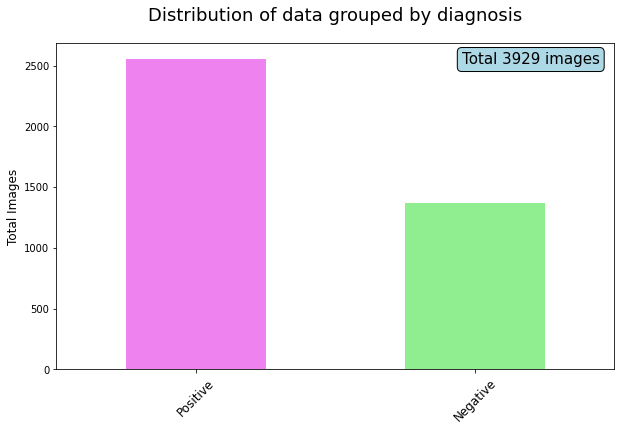

In [78]:
# Plot
ax = dataset.tumor.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightgreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(dataset.tumor.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(dataset)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );



Data visualisation


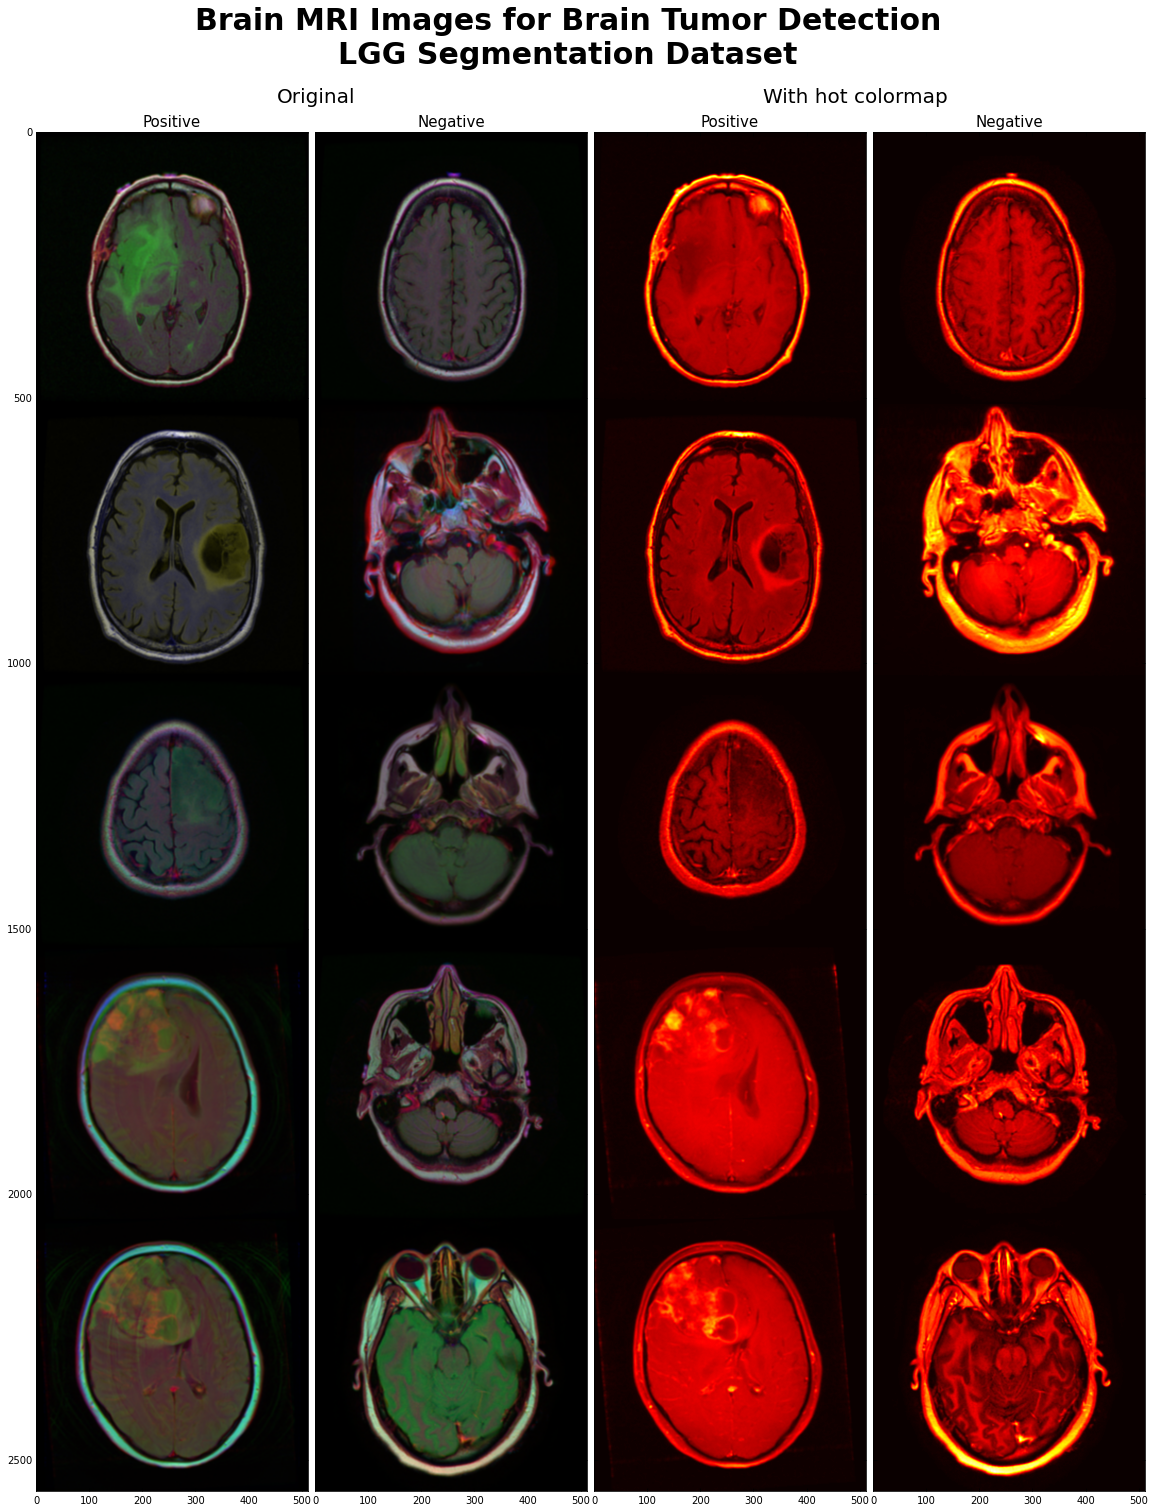

In [87]:
# Data
sample_yes_df = dataset[dataset["tumor"] == 1].sample(5).image_path.values
sample_no_df = dataset[dataset["tumor"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Data preparation

In [56]:
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn

In [49]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [50]:
data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std)
])

In [61]:
from torchvision import datasets, transforms
from torch.utils import data

dataset_full = datasets.ImageFolder(root = data_path_2, 
                transform = transforms.ToTensor())

loader = data.DataLoader(dataset_full, batch_size = 8, shuffle = True)

In [63]:
from sklearn.model_selection import train_test_split

In [67]:
loader.dataset

Dataset ImageFolder
    Number of datapoints: 7858
    Root location: ../dataset_mri/kaggle_3m/
    StandardTransform
Transform: ToTensor()

In [68]:
np.random.seed(42)
samples_train, samples_test = train_test_split(loader.dataset)
samples_train, samples_val = train_test_split(samples_train,test_size=0.2)

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 4714
Nombre d'images de val : 1179
Nombre d'images de test : 1965


Classifier

In [40]:
from model_classifier import *

In [41]:
def build_model():
    model = Net()
    # defining the optimizer
    optimizer = Adam(model.parameters(), lr=0.07)
    # defining the loss function
    criterion = CrossEntropyLoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda() 

In [42]:
model=build_model()

In [44]:
# we use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#puts model to gpu or cpu
model.to(device)

cpu


AttributeError: 'NoneType' object has no attribute 'to'